In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [4]:
df = pd.read_parquet("cmm_erdos_bootcamp_2020_timeseries.pq", engine='pyarrow')
df.date_val = pd.to_datetime(df.date_val)

# Moving average smoothing

In [3]:
def ma(vals, k):
    """Performs moving average smoothing. k determines how many points
    on each side of a point to include in the average."""
    res = vals[k : len(vals)-k]
    for j in range(k):
        i = j + 1
        res = res + vals[k-i : len(vals)-k-i]
        res = res + vals[k+i : len(vals)-k+i]
        
    res = res / (2*k + 1)
    
    # concatenate extra stuff on each side of res just to make it
    # have the same shape as vals
    res = np.concatenate([res[:k], res, res[-k:]])
    
    return res

In [4]:
def find_trend(vals, holiday_inds=None, ax=None, label=""):
    vals_copy = vals.copy()
    
    # taming the holidays if their indices are provided
    if holiday_inds is not None:
        for i in holiday_inds:
            vals_copy[i] = vals_copy[i - 7]

    season_washed_away = ma(vals_copy, 3) # 3 because 3+1+3=7 is the period
    trend = ma(season_washed_away, 20) # 20 was chosen arbitrarily

    if ax is not None:
        ax.plot(season_washed_away, lw=1, label=label)
        ax.plot(trend, lw=1, c='r')
        ax.legend()
    
    return season_washed_away, trend

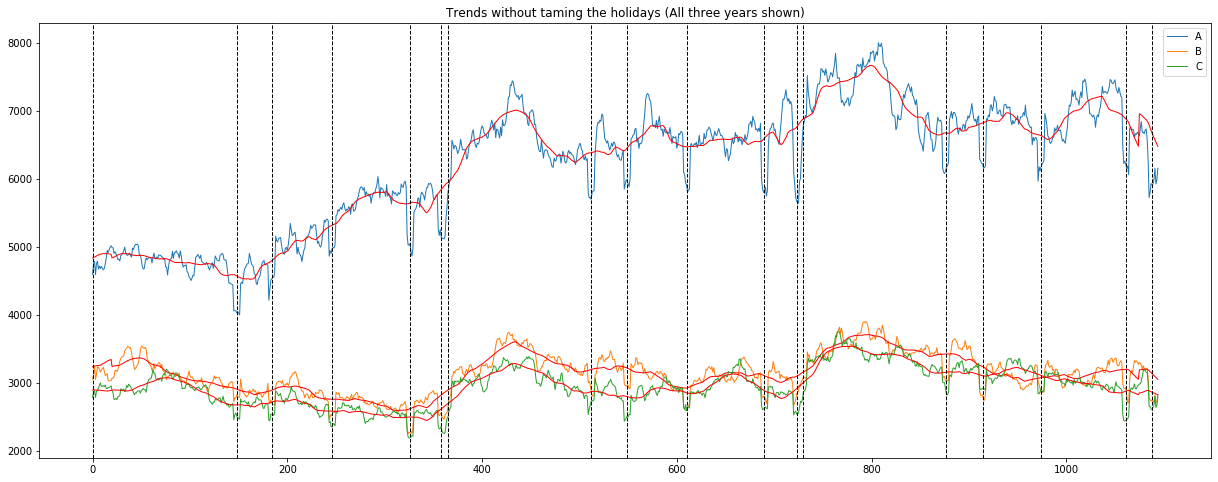

In [5]:
fig, ax = plt.subplots(figsize=(21, 8))
ax.set_title("Trends without taming the holidays (All three years shown)")

find_trend(df.volume_A.values, None, ax, label="A")
find_trend(df.volume_B.values, None, ax, label="B")
find_trend(df.volume_C.values, None, ax, label="C")


# plot vertical lines for the holidays locaions
for ind in df.index[df.is_holiday == 1]:
    ax.axvline(ind, lw=1, ls='--', c='k')

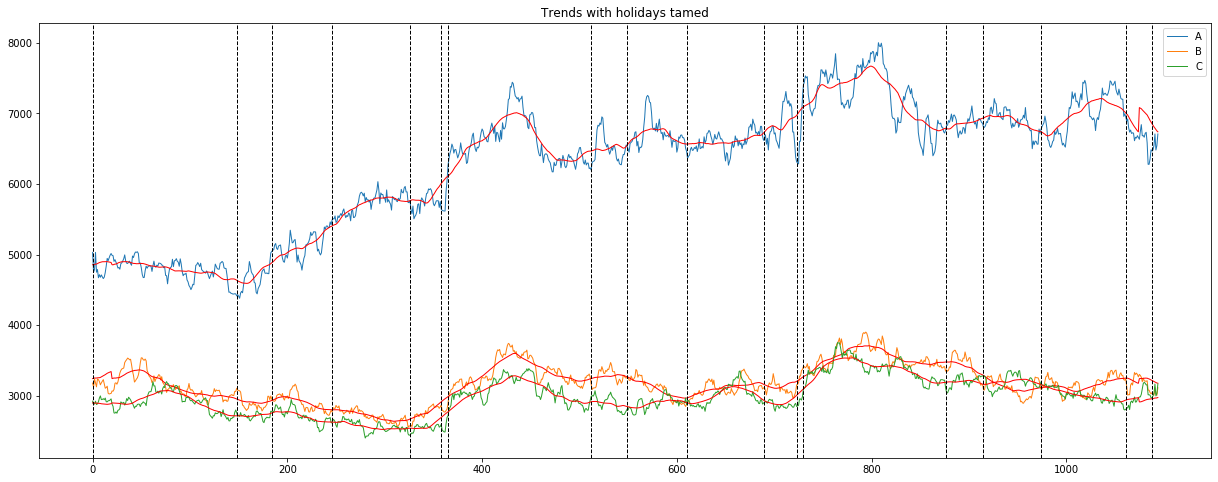

In [6]:
fig, ax = plt.subplots(figsize=(21, 8))
ax.set_title("Trends with holidays tamed")

holiday_inds = df.index[df.is_holiday == 1]

find_trend(df.volume_A.values, holiday_inds, ax, label="A")
find_trend(df.volume_B.values, holiday_inds, ax, label="B")
find_trend(df.volume_C.values, holiday_inds, ax, label="C")


# plot vertical lines for the holidays locaions
for ind in holiday_inds:
    ax.axvline(ind, lw=1, ls='--', c='k')

# Trend Extraction Using STL Decomposition

In [1]:
from statsmodels.tsa.seasonal import STL

In [39]:
vol_a = df.volume_A.values.copy()
vol_b = df.volume_B.values.copy()
vol_c = df.volume_C.values.copy()

for i in df.index[df.is_holiday == 1]:
    vol_a[i] = vol_a[i - 7]
    vol_b[i] = vol_b[i - 7]
    vol_c[i] = vol_c[i - 7]

trend_a = STL(vol_a, 7).fit().trend
trend_b = STL(vol_b, 7).fit().trend
trend_c = STL(vol_c, 7).fit().trend

In [45]:
def normalize(vals):
    return (vals - vals.mean()) / (vals.max() - vals.min())

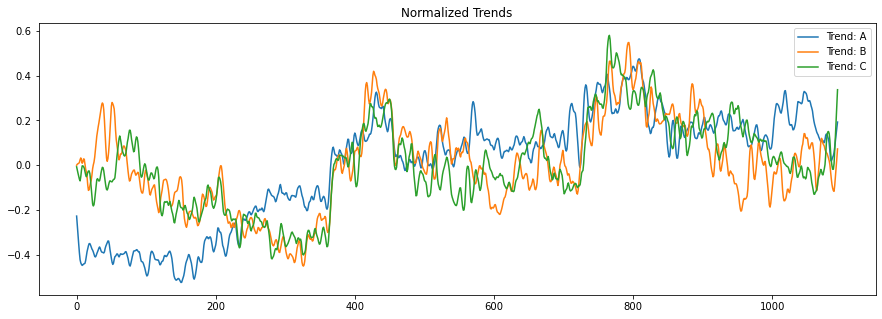

In [50]:
plt.figure(figsize=(15, 5))

plt.title("Normalized Trends")
plt.plot(normalize(trend_a), label="Trend: A")
plt.plot(normalize(trend_b), label="Trend: B")
plt.plot(normalize(trend_c), label="Trend: C")
plt.legend()

plt.show()